In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import pandas as pd
import os
import random
import csv
from sys import platform
from IPython.core.display import HTML
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

/Users/abir.deb/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/abir.deb/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def compute_stats(metric, df):
    '''
    compute mean, std, and % CV on a metric for each team's models;
    expects metric to be a string; df is a dataframe that contains the model metrics
    '''
    #compute metrics
    mean = df.pivot(index = 'team', columns = 'year', values = metric).mean(axis = 1)
    std = df.pivot(index = 'team', columns = 'year', values = metric).std(axis = 1)
    cv = std / mean * 100
    
    #return in a list
    to_return_lst = [mean.sort_values(), std.sort_values(), cv.sort_values()]
    
    return to_return_lst



def load_standings(filePath, year):
    '''
    loads standings data into a dataframe and returns it
    '''
    file_name = 'Regular_Season_Standings'
    full_path = filePath + str(year) + '_' + file_name + '.csv'
    df = pd.DataFrame.from_csv(full_path)
    
    #reset index
    df = df.reset_index()
    
    #add a column for year
    df['year'] = year
    
    #remove '*' and '+' from end of team names
    df.Tm = df.Tm.apply(str.strip, args = ('+')).apply(str.strip, args = '*')
        
    return df

*Let's read in the csv file with metric results for each team's models into a dataframe*

**3 models per team (a model each year, 2014-2016)**

In [3]:
#make sure directory paths are correct based on running in a Windows/Unix environment
if platform == 'win32':
    #code is running in a windows machine
    filePath = os.getcwd() + '\\armchair_all_data_model_metrics.csv'
    stats_df_path = os.getcwd() + '\\armchair_team_based_model_metrics_stats.csv'
    df = pd.DataFrame.from_csv(filePath)
else:
    filePath = os.getcwd() + '/armchair_all_data_model_metrics.csv'
    stats_df_path = os.getcwd() + '/armchair_team_based_model_metrics_stats.csv'
    df = pd.DataFrame.from_csv(filePath)

In [4]:
df.head()

,year,team,train_accuracy_score_no_grid,test_accuracy_score_no_grid,five_fold_cv_score_no_grid,best_reg,test_accuracy_best_reg,precision,recall,f1_score,auc
0,2014,ARI,0.769452,0.757143,0.762308,0.1,0.757143,0.682927,0.743363,0.711864,0.810397
1,2014,ATL,0.749650,0.733083,0.707692,0.1,0.729323,0.586777,0.763441,0.663551,0.779725
2,2014,BAL,0.734513,0.682119,0.701608,0.1,0.682119,0.656489,0.627737,0.641791,0.768016
3,2014,BUF,0.755650,0.671815,0.700659,0.1,0.691120,0.611111,0.550000,0.578947,0.748491
4,2014,CAR,0.661597,0.651685,0.626026,0.1,0.654494,0.654135,0.530488,0.585859,0.717734


*What's the distribution of the precision, recall, f1 score, and AUC for all of the models irrespective 
of team and year?*

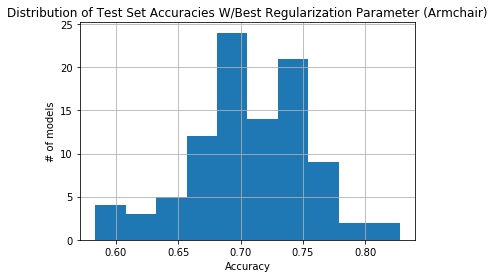

In [5]:
test_accuracy_best_reg_hist = plt.hist(df.test_accuracy_best_reg)
plt.title('Distribution of Test Set Accuracies W/Best Regularization Parameter (Armchair)')
plt.ylabel('# of models')
plt.xlabel('Accuracy')
plt.grid(True)
plt.show()

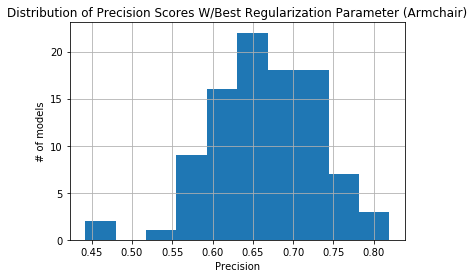

In [6]:
precision_hist = plt.hist(df.precision)
plt.title('Distribution of Precision Scores W/Best Regularization Parameter (Armchair)')
plt.ylabel('# of models')
plt.xlabel('Precision')
plt.grid(True)
plt.show()

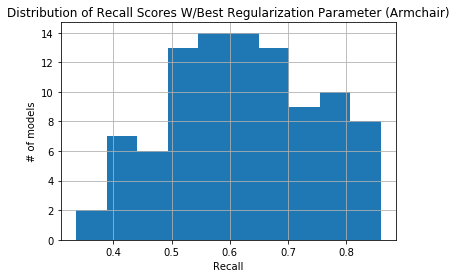

In [7]:
recall_hist = plt.hist(df.recall)
plt.title('Distribution of Recall Scores W/Best Regularization Parameter (Armchair)')
plt.ylabel('# of models')
plt.xlabel('Recall')
plt.grid(True)
plt.show()

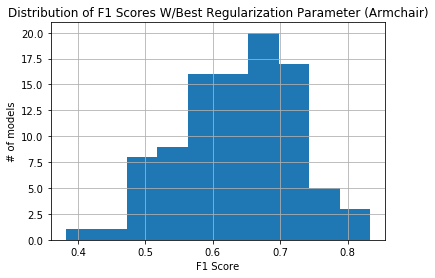

In [8]:
f1_score_hist = plt.hist(df.f1_score)
plt.title('Distribution of F1 Scores W/Best Regularization Parameter (Armchair)')
plt.ylabel('# of models')
plt.xlabel('F1 Score')
plt.grid(True)
plt.show()

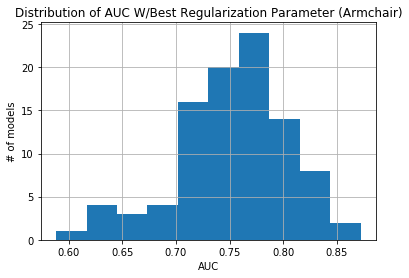

In [9]:
auc_hist = plt.hist(df.auc)
plt.title('Distribution of AUC W/Best Regularization Parameter (Armchair)')
plt.ylabel('# of models')
plt.xlabel('AUC')
plt.grid(True)
plt.show()

*What's the median precision, recall, f1 score, and AUC for each team's model?*

In [10]:
df.median()

year                            2015.000000
train_accuracy_score_no_grid       0.744183
test_accuracy_score_no_grid        0.709195
five_fold_cv_score_no_grid         0.718343
best_reg                           0.100000
test_accuracy_best_reg             0.705698
precision                          0.665525
recall                             0.614639
f1_score                           0.643118
auc                                0.758162
dtype: float64

*What's the average precision, recall, f1 score, and AUC for each team's model?*

In [11]:
df.mean()

year                            2015.000000
train_accuracy_score_no_grid       0.748033
test_accuracy_score_no_grid        0.706904
five_fold_cv_score_no_grid         0.720033
best_reg                           1.138562
test_accuracy_best_reg             0.706519
precision                          0.665997
recall                             0.620949
f1_score                           0.636534
auc                                0.753488
dtype: float64

*What's the standard deviation of the precision, recall, f1 score, and AUC for each team's model?*

In [12]:
df.std()

year                             0.820783
train_accuracy_score_no_grid     0.040569
test_accuracy_score_no_grid      0.047546
five_fold_cv_score_no_grid       0.049562
best_reg                        10.196224
test_accuracy_best_reg           0.047995
precision                        0.065331
recall                           0.128327
f1_score                         0.086032
auc                              0.052330
dtype: float64

*What's the % CV for precision, recall, f1 score, and AUC for each team's model?*

In [13]:
df.std() / df.mean() * 100

year                              0.040734
train_accuracy_score_no_grid      5.423437
test_accuracy_score_no_grid       6.725936
five_fold_cv_score_no_grid        6.883345
best_reg                        895.534824
test_accuracy_best_reg            6.793102
precision                         9.809548
recall                           20.666335
f1_score                         13.515735
auc                               6.944994
dtype: float64

*Do these metrics vary by year for each team or are they relatively consistent?*

**Gather accuracy, precision, recall, f1 score, and AUC stats**

In [14]:
acc_score_best_reg_means, acc_score_best_reg_std, acc_score_best_reg_cvs = compute_stats('test_accuracy_best_reg', df)
precision_means, precision_stds, precision_cvs = compute_stats('precision', df)
recall_means, recall_stds, recall_cvs = compute_stats('recall', df)
f1_means, f1_stds, f1_cvs = compute_stats('f1_score', df)
auc_means, auc_stds, auc_cvs = compute_stats('auc', df)

#explicit join of all data frames
all_stats_df = (
acc_score_best_reg_means.to_frame('acc_score_best_reg_means').join(acc_score_best_reg_std.to_frame(
'acc_score_best_reg_std')).join(acc_score_best_reg_cvs.to_frame('acc_score_best_reg_cvs')).join(
precision_means.to_frame('precision_means')).join(precision_stds.to_frame('precision_stds')).join(
precision_cvs.to_frame('precision_cvs')).join(recall_means.to_frame('recall_means')).join(
recall_stds.to_frame('recall_stds')).join(recall_cvs.to_frame('recall_cvs')).join(
f1_means.to_frame('f1_means')).join(f1_stds.to_frame('f1_stds')).join(f1_cvs.to_frame('f1_cvs')).join(
auc_means.to_frame('auc_means')).join(auc_stds.to_frame('auc_stds')).join(auc_cvs.to_frame('auc_cvs'))
)

#write model validation statistics results to csv file
all_stats_df.to_csv(stats_df_path)

**Mean precision in each team's models**

In [15]:
precision_means

team
IND    0.547691
CLE    0.606684
KC     0.621329
SF     0.622361
GB     0.631744
BAL    0.636525
WAS    0.637193
SEA    0.637812
MIA    0.637938
PHI    0.639681
NO     0.640534
BUF    0.641691
OAK    0.645309
HOU    0.649407
CHI    0.650725
DEN    0.656051
JAC    0.657049
NE     0.660962
ATL    0.661024
NYJ    0.666582
DET    0.667791
CAR    0.685305
MIN    0.687609
CIN    0.690523
ARI    0.692126
TB     0.695815
LA     0.714841
TEN    0.716860
PIT    0.724771
NYG    0.734713
SD     0.764160
DAL    0.789107
dtype: float64

**Standard Deviation in precision for each team's models**

In [16]:
precision_stds

team
TB     0.015374
PIT    0.017161
NYG    0.021935
BAL    0.023175
DAL    0.025185
TEN    0.025399
WAS    0.028404
LA     0.030082
CIN    0.030716
MIN    0.030734
BUF    0.031272
SEA    0.034124
KC     0.037776
CLE    0.038301
SF     0.038960
NE     0.041536
GB     0.042968
ARI    0.043147
NO     0.043301
JAC    0.044008
SD     0.048762
CAR    0.050224
CHI    0.055486
OAK    0.055633
DEN    0.060151
DET    0.061892
ATL    0.068659
HOU    0.069125
NYJ    0.078329
IND    0.079266
PHI    0.079274
MIA    0.170031
dtype: float64

**% CV (Coefficient of Variation) in precision for each team's models**

In [17]:
precision_cvs

team
TB      2.209426
PIT     2.367826
NYG     2.985488
DAL     3.191593
TEN     3.543154
BAL     3.640784
LA      4.208260
CIN     4.448232
WAS     4.457706
MIN     4.469655
BUF     4.873302
SEA     5.350235
KC      6.079855
ARI     6.233924
SF      6.260007
NE      6.284142
CLE     6.313131
SD      6.381149
JAC     6.697907
NO      6.760185
GB      6.801436
CAR     7.328733
CHI     8.526750
OAK     8.621198
DEN     9.168586
DET     9.268204
ATL    10.386784
HOU    10.644394
NYJ    11.750793
PHI    12.392792
IND    14.472742
MIA    26.653227
dtype: float64

**Mean recall in each team's models**

In [18]:
recall_means

team
PHI    0.442473
GB     0.449979
MIA    0.461849
OAK    0.521386
CAR    0.526949
BAL    0.527428
JAC    0.532213
SD     0.543765
DEN    0.549652
CHI    0.553735
BUF    0.554750
DET    0.563923
SEA    0.570797
KC     0.573652
CLE    0.577633
IND    0.603045
NYJ    0.613411
PIT    0.614039
SF     0.614952
TEN    0.637745
WAS    0.652503
CIN    0.663494
NYG    0.688087
ATL    0.703863
HOU    0.709395
MIN    0.709989
ARI    0.749563
NE     0.755913
NO     0.770962
LA     0.790285
TB     0.805910
DAL    0.837028
dtype: float64

**Standard Deviation in recall for each team's models**

In [19]:
recall_stds

team
NO     0.009140
PIT    0.010691
NYJ    0.012298
DAL    0.022495
JAC    0.023972
LA     0.029263
NE     0.036861
DEN    0.037907
HOU    0.038084
TEN    0.038187
GB     0.043918
ARI    0.044654
ATL    0.051596
PHI    0.051672
KC     0.058533
TB     0.066095
CIN    0.073350
BUF    0.076972
OAK    0.080070
CAR    0.082613
SF     0.088475
BAL    0.089794
SEA    0.094348
IND    0.106473
CHI    0.113031
NYG    0.122554
WAS    0.130540
SD     0.135417
MIN    0.139796
DET    0.149901
CLE    0.180702
MIA    0.187130
dtype: float64

**% CV in recall for each team's models**

In [20]:
recall_cvs

team
NO      1.185502
PIT     1.741039
NYJ     2.004906
DAL     2.687534
LA      3.702827
JAC     4.504230
NE      4.876409
HOU     5.368501
ARI     5.957282
TEN     5.987799
DEN     6.896616
ATL     7.330395
TB      8.201304
GB      9.760081
KC     10.203644
CIN    11.055126
PHI    11.677924
BUF    13.875058
SF     14.387250
OAK    15.357225
CAR    15.677586
SEA    16.529091
BAL    17.024990
IND    17.655934
NYG    17.810767
MIN    19.689851
WAS    20.005971
CHI    20.412401
SD     24.903512
DET    26.581770
CLE    31.283242
MIA    40.517622
dtype: float64

**Mean f1 score in each team's models**

In [21]:
f1_means

team
PHI    0.523027
GB     0.524362
MIA    0.526520
IND    0.571731
BAL    0.575093
OAK    0.576316
CLE    0.581855
JAC    0.587874
BUF    0.593673
CAR    0.594654
DEN    0.595631
KC     0.596270
CHI    0.596369
DET    0.598064
SEA    0.598550
SF     0.617533
SD     0.627388
NYJ    0.637743
WAS    0.641833
PIT    0.664697
TEN    0.674872
CIN    0.676030
HOU    0.677010
ATL    0.678314
MIN    0.695816
NO     0.698987
NE     0.703796
NYG    0.707782
ARI    0.717971
TB     0.746313
LA     0.750649
DAL    0.812351
dtype: float64

**Standard Deviation in f1 score for each team's models**

In [22]:
f1_stds

team
DEN    0.004348
ARI    0.005799
PIT    0.007537
NE     0.008863
ATL    0.017278
NO     0.022864
DAL    0.023783
LA     0.029435
JAC    0.029756
TEN    0.031960
GB     0.033699
TB     0.036907
NYJ    0.039931
SEA    0.042442
HOU    0.048261
KC     0.048495
CIN    0.051584
BUF    0.053699
SF     0.060903
BAL    0.061264
PHI    0.062224
CAR    0.070056
OAK    0.070593
WAS    0.073120
NYG    0.073129
DET    0.076033
IND    0.077807
SD     0.080742
MIN    0.082995
CHI    0.087364
CLE    0.101260
MIA    0.161752
dtype: float64

**% CV in f1 score for each team's models**

In [23]:
f1_cvs

team
DEN     0.729979
ARI     0.807735
PIT     1.133845
NE      1.259247
ATL     2.547207
DAL     2.927614
NO      3.271006
LA      3.921313
TEN     4.735758
TB      4.945245
JAC     5.061619
NYJ     6.261238
GB      6.426670
SEA     7.090821
HOU     7.128569
CIN     7.630408
KC      8.133007
BUF     9.045294
SF      9.862252
NYG    10.332086
BAL    10.652922
WAS    11.392374
CAR    11.780958
PHI    11.896953
MIN    11.927759
OAK    12.248992
DET    12.713216
SD     12.869578
IND    13.609094
CHI    14.649283
CLE    17.402922
MIA    30.721035
dtype: float64

**Mean AUC in each team's models**

In [24]:
auc_means

team
PHI    0.688742
BUF    0.690491
KC     0.699470
SEA    0.699571
SF     0.701095
MIA    0.704440
GB     0.707102
IND    0.709777
OAK    0.718081
HOU    0.724847
CAR    0.728106
JAC    0.737454
CLE    0.740051
NYJ    0.741909
CHI    0.746459
DEN    0.748874
TEN    0.750240
BAL    0.758363
CIN    0.758917
WAS    0.764726
DET    0.771726
MIN    0.783271
NE     0.787864
PIT    0.790355
TB     0.796598
ATL    0.796633
NYG    0.797023
SD     0.800124
NO     0.808135
LA     0.812664
ARI    0.816159
DAL    0.832360
dtype: float64

**Standard Deviation in AUC for each team's models**

In [25]:
auc_stds

team
TEN    0.001603
PIT    0.003287
LA     0.006982
NO     0.011819
ARI    0.012928
DET    0.013508
HOU    0.014635
ATL    0.014844
NYJ    0.019514
TB     0.019923
CHI    0.020388
BAL    0.020436
CIN    0.022323
NE     0.022367
JAC    0.023868
CAR    0.024937
DEN    0.025216
SD     0.025979
NYG    0.030575
OAK    0.030830
CLE    0.035884
GB     0.037021
WAS    0.038026
IND    0.039894
DAL    0.048166
MIN    0.050591
PHI    0.055147
BUF    0.056803
SEA    0.057657
KC     0.064889
SF     0.068701
MIA    0.102899
dtype: float64

**% CV in f1 score for each team's models**

In [26]:
auc_cvs

team
TEN     0.213599
PIT     0.415934
LA      0.859197
NO      1.462442
ARI     1.584028
DET     1.750343
ATL     1.863392
HOU     2.019107
TB      2.501028
NYJ     2.630251
BAL     2.694738
CHI     2.731350
NE      2.838981
CIN     2.941387
JAC     3.236540
SD      3.246845
DEN     3.367123
CAR     3.424931
NYG     3.836187
OAK     4.293390
CLE     4.848834
WAS     4.972544
GB      5.235644
IND     5.620644
DAL     5.786676
MIN     6.458907
PHI     8.006989
BUF     8.226480
SEA     8.241746
KC      9.276877
SF      9.799113
MIA    14.607161
dtype: float64